In [1]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from math import sqrt
import scipy as sp
from scipy import stats
import scipy.signal
from scipy.signal import fftconvolve, convolve
import matplotlib.pyplot as plt
import seaborn as sns
from ipywidgets import interact
import random as ran

from datetime import datetime
from datetime import timedelta
from dateutil.relativedelta import *

from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV, LogisticRegression
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, KFold, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, HashingVectorizer, ENGLISH_STOP_WORDS
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn import datasets
from textblob import TextBlob, Word
from nltk.stem.snowball import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from textacy.preprocess import preprocess_text

from gensim import corpora, models, matutils
from collections import defaultdict, Counter

import statsmodels.api as sm
import statsmodels.formula.api as sm
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX

import tensorflow as tf

import patsy
from itertools import combinations

import graphviz
import json
import requests
import urllib
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from time import sleep
import re
import twitter

%matplotlib inline
#plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Build and document a working model, prototype, recommendation, or solution

Note: The new Statcast metrics are available beginning from the 2015 baseball season to the current season. I downloaded the 2015-2017 baseball season data for all teams which will be used in the data modeling.

## [pybaseball](https://github.com/jldbc/pybaseball) 
Pull current and historical baseball statistics using Python (Statcast, Baseball Reference, FanGraphs)

`pybaseball` is a Python package for baseball data analysis. This package scrapes Baseball Reference, Baseball Savant, and FanGraphs so you don't have to. The package retrieves statcast data, pitching stats, batting stats, division standings/team records, awards data, and more. Data is available at the individual pitch level, as well as aggregated at the season level and over custom time periods. See the [docs](https://github.com/jldbc/pybaseball/tree/master/docs) for a comprehensive list of data acquisition functions.

**Statcast**

The statcast function retrieves pitch-level statcast data for a given date or range or dates.

statcast(start_dt=[yesterday's date], end_dt=None, team=None)

In [2]:
# Pull advanced metrics from Major League Baseball's Statcast system
#from pybaseball import statcast

# Look up a player's MLBAM, Retrosheet, FanGraphs, and Baseball Reference ID by name
#from pybaseball import playerid_lookup

### Reading a File

In [3]:
# Create data path variable for loading data
data_path = '/Users/yangweichle/Documents/GeneralAssembly/Projects/Datasets/'

In [4]:
# Read file into DataFrame
# Note: header=0 disables the header from the file
all_MLB_teams2015_2017 = pd.read_csv(data_path + 'all_MLB_teams2015_2017.csv', header=0) # Comma-separated values file

### Examine the DataFrame

In [5]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017.shape[0], all_MLB_teams2015_2017.shape[1]))

Rows: 2139920, Cols: 91


In [6]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2139920 entries, 0 to 2139919
Data columns (total 91 columns):
Unnamed: 0                         int64
index                              int64
pitch_type                         object
game_date                          object
release_speed                      float64
release_pos_x                      float64
release_pos_z                      float64
player_name                        object
batter                             float64
pitcher                            float64
events                             object
description                        object
spin_dir                           float64
spin_rate_deprecated               float64
break_angle_deprecated             float64
break_length_deprecated            float64
zone                               float64
des                                object
game_type                          object
stand                              object
p_throws                           obje

In [7]:
# Column names (which is "an index")
#all_MLB_teams2015_2017.columns

In [8]:
# Sort a DataFrame by multiple columns
# Note: ascending: sort ascending vs. descending; ascending=True is default
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017.sort_values(by=['game_date', 'game_pk', 'at_bat_number', 'pitch_number'], ascending=True, inplace=True)

In [9]:
# Print the first 5 rows and the last 5 rows of the DataFrame
all_MLB_teams2015_2017.head().append(all_MLB_teams2015_2017.tail())

,Unnamed: 0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2139919,702491,17584,FF,2015-04-05,93.6,2.5520,5.5293,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139918,702490,17583,FF,2015-04-05,93.4,2.5694,5.6476,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139917,702489,17582,FF,2015-04-05,94.8,2.6266,5.2936,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139916,702488,17581,FF,2015-04-05,91.6,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
2139915,702487,17580,CU,2015-04-05,75.9,NaN,NaN,Jon Lester,572761.0,452657.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN
4,4,650,FT,2017-10-01,95.9,-0.8903,6.1341,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
3,3,636,CH,2017-10-01,82.8,-0.9901,6.0626,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
2,2,620,FF,2017-10-01,94.7,-0.6208,6.3387,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
1,1,615,FC,2017-10-01,91.8,-1.0777,6.1772,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,Infield shift,Strategic
0,0,597,FC,2017-10-01,91.9,-1.1948,5.9921,Roberto Osuna,595885.0,532077.0,...,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,NaN,NaN


#### Identifying important columns to include in the DataFrame.

In [10]:
# Select multiple columns
# Note: release_speed = Pitch Velocity (MPH)
#       bb_type = Batted Ball Type
#       launch_speed = Exit Velocity (MPH)
#       launch_angle = Launch Angle (Degrees)
baseball_cols = ['game_date', 'home_team', 'away_team', 'player_name', 'pitcher', 'pitch_type', 'pitch_name', 'release_speed',
                 'batter', 'events', 'description', 'bb_type', 'des', 'launch_speed', 'launch_angle', 'hit_distance_sc'] 
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017[baseball_cols]

In [11]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 2139920, Cols: 16


In [12]:
# Print the first 5 rows of the DataFrame
all_MLB_teams2015_2017_new.head()

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,release_speed,batter,events,description,bb_type,des,launch_speed,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN


In [13]:
# Rename one or more columns in the original DataFrame rather than returning a new view
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.rename(columns={'release_speed': 'pitch_velocity',
                                                                        'bb_type': 'batted_ball_type',
                                                                        'launch_speed': 'exit_velocity'})

In [14]:
# Print a concise summary of a DataFrame including the index dtype and column dtypes, non-null values, and memory usage
# Note: Useful to quickly see if null values exist 
all_MLB_teams2015_2017_new.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2139920 entries, 2139919 to 0
Data columns (total 16 columns):
game_date           object
home_team           object
away_team           object
player_name         object
pitcher             float64
pitch_type          object
pitch_name          object
pitch_velocity      float64
batter              float64
events              object
description         object
batted_ball_type    object
des                 object
exit_velocity       float64
launch_angle        float64
hit_distance_sc     float64
dtypes: float64(6), object(10)
memory usage: 277.5+ MB


### Handling Missing Values

In [15]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date                 0
home_team                 0
away_team                 0
player_name               0
pitcher                   0
pitch_type             3814
pitch_name             3814
pitch_velocity         2505
batter                    0
events              1586052
description               0
batted_ball_type    1752979
des                 1586054
exit_velocity       1585044
launch_angle        1585019
hit_distance_sc     1631442
dtype: int64

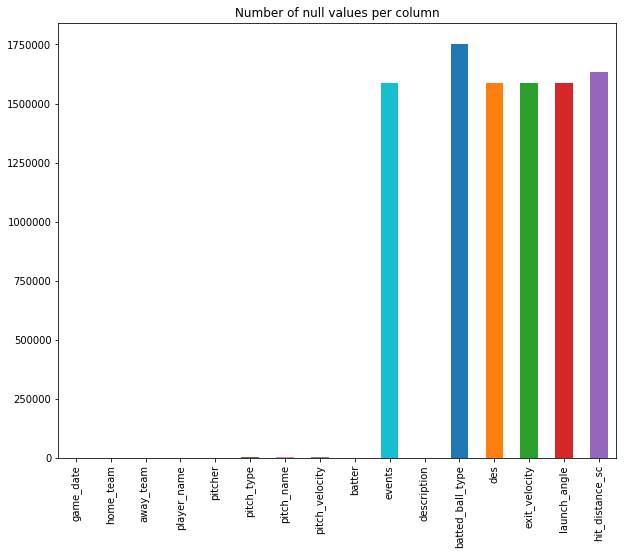

In [16]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

#### Approach for excluding records:

Each record represents an interaction between a pitcher and a batter (i.e., a pitch thrown by the pitcher to the batter).  The goal is to keep any interaction for which Statcast could provide valid measurements for the metrics `launch_speed`, `launch_angle`, and `hit_distance_sc`.

In order to do so, non-batted ball records will be excluded. <br>

- Drop all `events` = NaN which represent interactions where the batter did not make contact with the ball or the batter made contact with the ball but it was hit foul (e.g., ball, foul, called strike, swinging strike, blocked ball, foul tip, intentional ball, foul bunt, swinging strike blocked, missed bunt, pitchout)

- Drop all `batted_ball_type` = NaN which represents other remaining events where there was not a batted ball (e.g., strikeout, walk, hit by pitch, intentional walk, caught stealing, etc.)

#### Examine `events` column for missingness.

In [17]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

NaN                             1586052
field_out                        223381
strikeout                        116120
single                            82491
walk                              42138
double                            24898
home_run                          16629
force_out                         11500
grounded_into_double_play         11266
hit_by_pitch                       5019
field_error                        4816
sac_fly                            3549
sac_bunt                           3149
triple                             2607
intent_walk                        1884
double_play                        1348
fielders_choice_out                 919
caught_stealing_2b                  696
strikeout_double_play               435
fielders_choice                     301
pickoff_caught_stealing_2b          131
other_out                           120
catcher_interf                      113
pickoff_1b                           95
sac_fly_double_play                  66


In [18]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#cubs2016_new.events.isna() # alias of isnull()
null_events = all_MLB_teams2015_2017_new.events.isnull()
all_MLB_teams2015_2017_new[null_events]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139919,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.6,572761.0,NaN,called_strike,NaN,NaN,NaN,NaN,NaN
2139918,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,93.4,572761.0,NaN,swinging_strike,NaN,NaN,NaN,NaN,NaN
2139917,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.8,572761.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139916,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.6,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139915,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,75.9,572761.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139913,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,94.0,518792.0,NaN,ball,NaN,NaN,92.6,10.5026,186.0
2139911,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139910,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.9,407812.0,NaN,ball,NaN,NaN,NaN,NaN,NaN
2139908,2015-04-05,CHC,STL,Jon Lester,452657.0,SI,Sinker,91.1,425509.0,NaN,foul,NaN,NaN,NaN,NaN,NaN
2139907,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.2,425509.0,NaN,foul,NaN,NaN,101.5,6.2577,186.0


#### What types of interactions occurred for missing `events`?

In [19]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_events].description.value_counts(dropna=False)

ball                       676751
foul                       371731
called_strike              333190
swinging_strike            131229
blocked_ball                45367
foul_tip                    10704
foul_bunt                    6228
intent_ball                  4724
swinging_strike_blocked      4312
missed_bunt                  1299
pitchout                      510
swinging_pitchout               4
foul_pitchout                   1
hit_into_play_score             1
hit_into_play                   1
Name: description, dtype: int64

#### Drop missing values from `events` column.

In [20]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['events'], inplace=True)

#### Examine `batted_ball_type` column for missingness.

In [21]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
NaN            166927
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [22]:
# Detect missing values in a Series
# Note: True if missing, False if not missing
#all_MLB_teams2015_2017_new.batted_ball_type.isna() # alias of isnull()
null_batted_ball_type = all_MLB_teams2015_2017_new.batted_ball_type.isnull()
all_MLB_teams2015_2017_new[null_batted_ball_type]

,game_date,home_team,away_team,player_name,pitcher,pitch_type,pitch_name,pitch_velocity,batter,events,description,batted_ball_type,des,exit_velocity,launch_angle,hit_distance_sc
2139906,2015-04-05,CHC,STL,Jon Lester,452657.0,CU,Curveball,76.8,425509.0,strikeout,swinging_strike,NaN,Jhonny Peralta strikes out swinging.,NaN,NaN,NaN
2139901,2015-04-05,CHC,STL,Jon Lester,452657.0,FC,Cutter,89.9,571431.0,strikeout,swinging_strike,NaN,Matt Adams strikes out swinging.,NaN,NaN,NaN
2139890,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FC,Cutter,84.9,519203.0,strikeout,called_strike,NaN,Anthony Rizzo called out on strikes.,NaN,NaN,NaN
2139882,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.0,425877.0,strikeout,swinging_strike,NaN,Yadier Molina strikes out swinging.,NaN,NaN,NaN
2139875,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,89.6,543939.0,walk,ball,NaN,Kolten Wong walks.,NaN,NaN,NaN
2139866,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,91.1,425794.0,strikeout,called_strike,NaN,Adam Wainwright called out on strikes.,NaN,NaN,NaN
2139864,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,88.7,518792.0,caught_stealing_2b,ball,NaN,"With Jason Heyward batting, Matt Carpenter cau...",NaN,NaN,NaN
2139854,2015-04-05,CHC,STL,Adam Wainwright,425794.0,CU,Curveball,77.1,592609.0,strikeout,swinging_strike_blocked,NaN,Mike Olt strikes out swinging.,NaN,NaN,NaN
2139849,2015-04-05,CHC,STL,Adam Wainwright,425794.0,FF,4-Seam Fastball,90.3,452657.0,strikeout,called_strike,NaN,Jon Lester called out on strikes.,NaN,NaN,NaN
2139837,2015-04-05,CHC,STL,Jon Lester,452657.0,FF,4-Seam Fastball,92.7,425509.0,strikeout,called_strike,NaN,Jhonny Peralta called out on strikes.,NaN,NaN,NaN


#### What types of `events` occurred for missing `batted_ball_type`?

In [23]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new[null_batted_ball_type].events.value_counts(dropna=False)

strikeout                       116120
walk                             42138
hit_by_pitch                      5019
intent_walk                       1884
caught_stealing_2b                 696
strikeout_double_play              435
pickoff_caught_stealing_2b         131
other_out                          120
catcher_interf                     113
pickoff_1b                          95
caught_stealing_3b                  56
pickoff_2b                          55
caught_stealing_home                29
run                                 16
pickoff_caught_stealing_3b          10
batter_interference                  4
pickoff_3b                           3
pickoff_caught_stealing_home         3
Name: events, dtype: int64

#### Drop missing values from `batted_ball_type` column.

In [24]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['batted_ball_type'], inplace=True)

#### Confirm whether the values for `events` and `batted_ball_type` are valid (i.e., values could provide valid measurements for Statcast metrics).

In [25]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.events.value_counts(dropna=False)

field_out                    223381
single                        82491
double                        24898
home_run                      16629
force_out                     11500
grounded_into_double_play     11266
field_error                    4816
sac_fly                        3549
sac_bunt                       3149
triple                         2607
double_play                    1348
fielders_choice_out             919
fielders_choice                 301
sac_fly_double_play              66
triple_play                      18
sac_bunt_double_play              3
Name: events, dtype: int64

In [26]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False)

ground_ball    178646
line_drive      99714
fly_ball        81752
popup           26829
Name: batted_ball_type, dtype: int64

In [27]:
all_MLB_teams2015_2017_new.batted_ball_type.value_counts(dropna=False).sum()

386941

In [28]:
# Compute a frequency table of two factors
pd.crosstab(all_MLB_teams2015_2017_new.events, all_MLB_teams2015_2017_new.batted_ball_type, margins=True, margins_name='Total', dropna=False)

batted_ball_type,fly_ball,ground_ball,line_drive,popup,Total
events,,,,,
double,3502,3342,17914,140,24898
double_play,222,109,930,87,1348
field_error,159,4349,199,109,4816
field_out,60230,103445,33726,25980,223381
fielders_choice,0,301,0,0,301
fielders_choice_out,0,914,2,3,919
force_out,47,11342,74,37,11500
grounded_into_double_play,0,11266,0,0,11266
home_run,11547,0,5082,0,16629


Note: The above frequencies confirm valid values.

In [29]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date               0
home_team               0
away_team               0
player_name             0
pitcher                 0
pitch_type            701
pitch_name            701
pitch_velocity        459
batter                  0
events                  0
description             0
batted_ball_type        0
des                     2
exit_velocity          66
launch_angle           66
hit_distance_sc     46472
dtype: int64

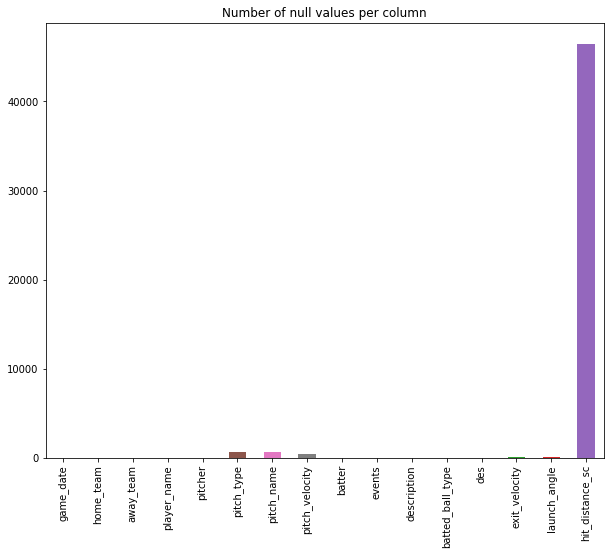

In [30]:
# Create a vertical bar plot by number of missing values per column using matplotlib
# Note: figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.isnull().sum().plot.bar(figsize=(10, 8));
plt.title('Number of null values per column');

Note: There are still missing values for the following variables: `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle`. These variables will be used in the modeling and observations with missing values will be dropped.

#### Drop missing values from `pitch_name`, `pitch_velocity`, `exit_velocity`, `launch_angle` columns.

In [31]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['pitch_name', 'pitch_velocity', 'exit_velocity', 'launch_angle'], inplace=True)

### Summarize the DataFrame

In [32]:
# Describe numeric columns
# Generates descriptive summary statistics of the central tendency, dispersion, and shape of the distribution
# Note: By default only numeric (int64) fields are returned
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).describe()

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
count,386112.000000,386112.000000,386112.000000,340221.000000
mean,88.938052,87.228387,10.662181,170.446680
std,5.809726,14.532315,27.245971,136.700367
min,41.500000,5.200000,-88.890000,0.000000
25%,85.100000,80.000000,-8.987000,22.000000
50%,90.300000,89.300000,10.605000,169.000000
75%,93.300000,98.100000,28.520775,294.000000
max,105.400000,123.400000,89.850000,504.000000


In [33]:
# Describe object columns (e.g. categorical, strings, or timestamps)
# Generates descriptive summary statistics of the count, unique values, top values, and frequency
# Note: "top" is the most common value; "freq" is the most common value's frequency
#       Excludes "NaN" (missing) values
# Remove multiple columns
# Note: axis=0 for rows, 1 for columns
all_MLB_teams2015_2017_new.drop(['home_team', 'away_team', 'player_name', 'des'], axis=1).describe(include='object')

,game_date,pitch_type,pitch_name,events,description,batted_ball_type
count,386112,386112,386112,386112,386112,386112
unique,537,16,16,16,4,4
top,2015-09-30,FF,4-Seam Fastball,field_out,hit_into_play,ground_ball
freq,974,131254,131254,222928,249245,178259


In [34]:
# Compute a frequency table of two factors
pd.crosstab(all_MLB_teams2015_2017_new.pitch_name, all_MLB_teams2015_2017_new.pitch_type, margins=True, margins_name='Total')

pitch_type,CH,CU,EP,FA,FC,FF,FO,FS,FT,KC,KN,PO,SC,SI,SL,UN,Total
pitch_name,,,,,,,,,,,,,,,,,
2-Seam Fastball,0,0,0,0,0,0,0,0,59444,0,0,0,0,0,0,0,59444
4-Seam Fastball,0,0,0,0,0,131254,0,0,0,0,0,0,0,0,0,0,131254
Changeup,43883,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,43883
Curveball,0,26046,0,0,0,0,0,0,0,0,0,0,0,0,0,0,26046
Cutter,0,0,0,0,21484,0,0,0,0,0,0,0,0,0,0,0,21484
Eephus,0,0,114,0,0,0,0,0,0,0,0,0,0,0,0,0,114
Fastball,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,3
Forkball,0,0,0,0,0,0,126,0,0,0,0,0,0,0,0,0,126
Knuckle Ball,0,0,0,0,0,0,0,0,0,0,2094,0,0,0,0,0,2094


#### Drop low frequency `pitch_name` observations

In [35]:
# Return elements, either from `x` or `y`, depending on `condition`
all_MLB_teams2015_2017_new['pitch_name_low_freq'] = np.where(all_MLB_teams2015_2017_new.pitch_name.isin(['Eephus', 'Fastball', 'Forkball', 'Pitch Out', 'Screwball', 'Unknown']), 1, 0)

In [36]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.pitch_name_low_freq.value_counts(dropna=False)

0    385848
1       264
Name: pitch_name_low_freq, dtype: int64

In [37]:
# Excluding low frequency values
all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new[all_MLB_teams2015_2017_new.pitch_name_low_freq == 0]
all_MLB_teams2015_2017_new.drop('pitch_name_low_freq', axis=1, inplace=True)

In [38]:
# Return the number of rows and columns (dimensionality) of the DataFrame
print('Rows: {}, Cols: {}'.format(all_MLB_teams2015_2017_new.shape[0], all_MLB_teams2015_2017_new.shape[1]))

Rows: 385848, Cols: 16


In [39]:
# Calculate the correlation matrix using the default method (Pearson correlation)
baseball_correlations = all_MLB_teams2015_2017_new.drop(['pitcher', 'batter'], axis=1).corr(method='pearson')
baseball_correlations

,pitch_velocity,exit_velocity,launch_angle,hit_distance_sc
pitch_velocity,1.000000,0.078758,0.006906,0.016692
exit_velocity,0.078758,1.000000,0.186630,0.352101
launch_angle,0.006906,0.186630,1.000000,0.732524
hit_distance_sc,0.016692,0.352101,0.732524,1.000000


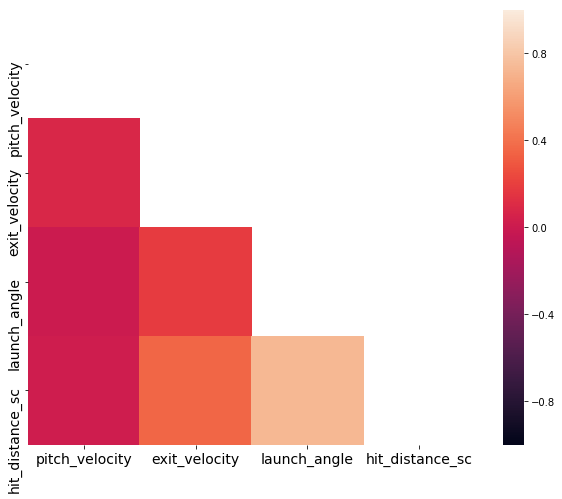

In [40]:
# Create a figure and a set of subplots
# Note: figsize: a tuple (width, height) in inches
fig, ax = plt.subplots(figsize=(10, 8));

# Return an array of zeros with the same shape and type as a given array
mask = np.zeros_like(baseball_correlations, dtype=np.bool)
# Return the indices for the upper-triangle of array
mask[np.triu_indices_from(mask)] = True

# Plot the correlation matrix (color-encoded) using Seaborn's .heatmap() function
# Note: vmin, vmax: values to anchor the colormap, otherwise they are inferred from the data & other keyword arguments
ax = sns.heatmap(baseball_correlations, vmin=-1, vmax=1, mask=mask, ax=ax);

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14);
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14);

plt.show();

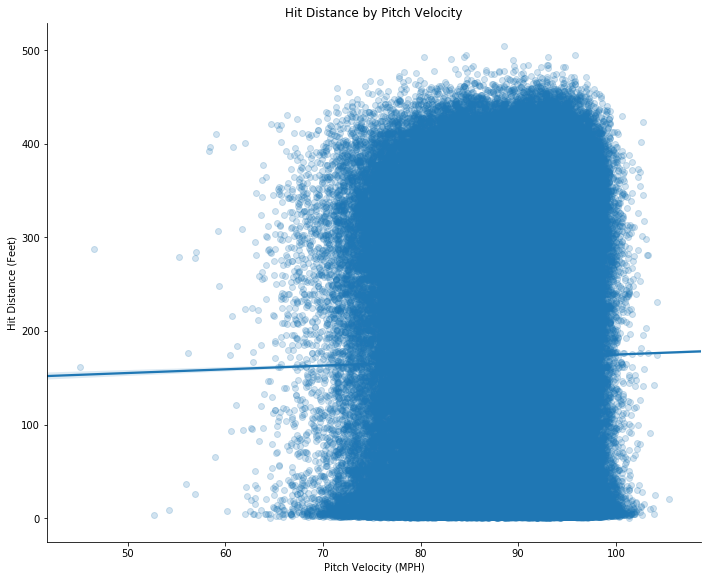

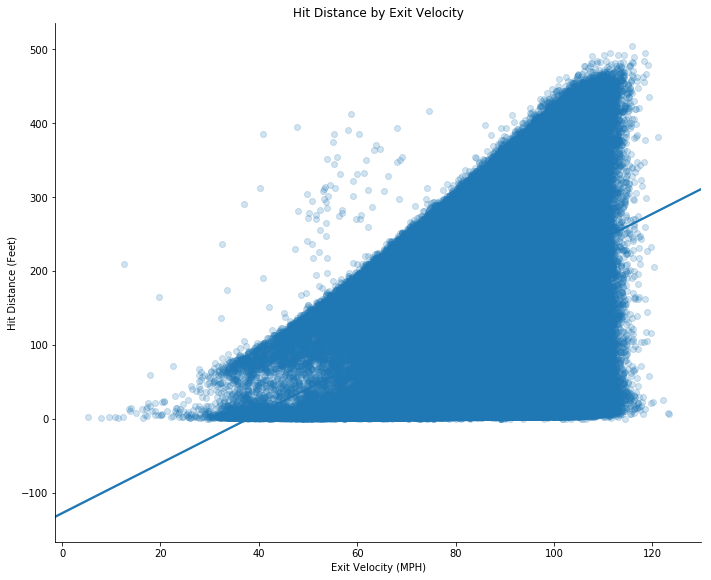

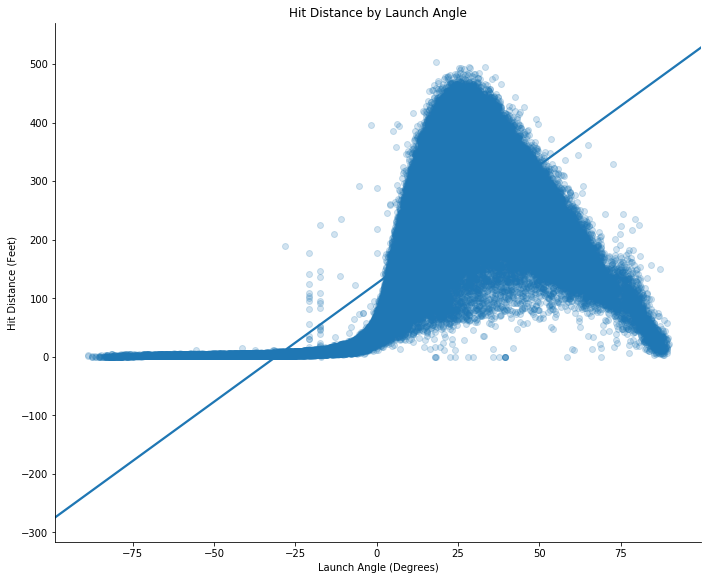

In [41]:
# Plot a simple linear relationship between two variables using Seaborn scatterplot with regression line
# Note: data: DataFrame name
#       fit_reg=True estimates and plots a regression model relating the x and y variables
#       size: height (in inches) of each facet
#       aspect: aspect ratio of each facet, so that "aspect * size" gives the width of each facet in inches
#       scatter_kws=alpha: blending value, between 0 (transparent) and 1 (opaque)
sns.lmplot(x='pitch_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, size=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Pitch Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Pitch Velocity');
plt.show()
sns.lmplot(x='exit_velocity', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, size=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Exit Velocity (MPH)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Exit Velocity');
plt.show()
sns.lmplot(x='launch_angle', y='hit_distance_sc', data=all_MLB_teams2015_2017_new, fit_reg=True, size=8, aspect=10/8, scatter_kws={'alpha':0.2});
plt.xlabel('Launch Angle (Degrees)');
plt.ylabel('Hit Distance (Feet)');
plt.title('Hit Distance by Launch Angle');

In [42]:
# Create feature column variables
feature_cols = ['pitch_velocity', 'exit_velocity', 'launch_angle']

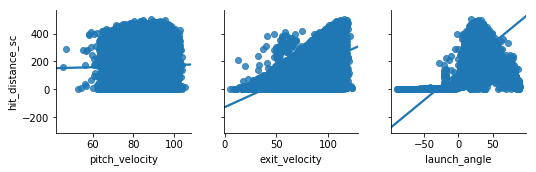

In [43]:
# Plot pairwise relationships (scatterplots for joint relationships) using Seaborn's .pairplot() function
# Note: kind: kind of plot for the non-identity relationships ('scatter' or 'reg')
sns.pairplot(all_MLB_teams2015_2017_new, x_vars=feature_cols, y_vars='hit_distance_sc', kind='reg');

In [44]:
# For each pitch name group, describe hit distance:
all_MLB_teams2015_2017_new.groupby(by='pitch_name').hit_distance_sc.describe()

,count,mean,std,min,25%,50%,75%,max
pitch_name,,,,,,,,
2-Seam Fastball,52265.0,153.447757,137.376798,0.0,14.0,125.0,281.00,493.0
4-Seam Fastball,116587.0,191.587784,134.702366,0.0,44.0,209.0,309.00,495.0
Changeup,38322.0,160.182924,136.715200,0.0,17.0,147.0,285.00,504.0
Curveball,23077.0,162.518958,134.347498,0.0,21.0,152.0,285.00,479.0
Cutter,18945.0,167.303299,134.805694,0.0,23.0,162.0,287.00,491.0
Knuckle Ball,1841.0,168.922868,137.441519,1.0,19.0,165.0,296.00,477.0
Knuckle Curve,6555.0,144.751945,133.654532,0.0,14.0,108.0,266.50,463.0
Sinker,28877.0,150.902206,137.648596,0.0,13.0,118.0,279.00,478.0
Slider,48085.0,168.338276,135.435076,0.0,22.0,166.0,289.00,495.0


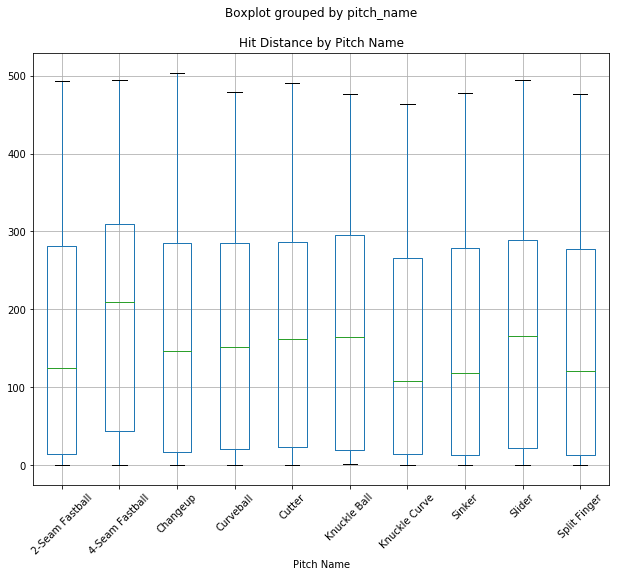

In [45]:
# Create box plots
# Note: column: used to limit data to a subset of columns
#       by: used to form box plots for separate groups
#       rot: rotation angle of labels (in degrees) with respect to the screen coordinate sytem
#       figsize: a tuple (width, height) in inches
all_MLB_teams2015_2017_new.boxplot(column='hit_distance_sc', by='pitch_name', rot=45, figsize=(10, 8));
plt.xlabel('Pitch Name');
plt.title('Hit Distance by Pitch Name');

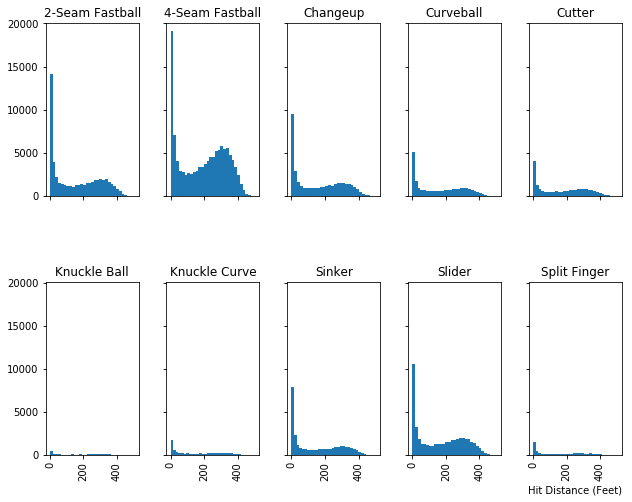

In [46]:
# Create histograms
# Note: column: used to limit data to a subset of columns
#       by: used to form histograms for separate groups
#       sharex: share x axis and set some x axis labels to invisible
#       sharey: share y axis and set some y axis labels to invisible
#       layout: tuple of (rows, columns) for the layout of the histograms
#       figsize: a tuple (width, height) in inches
#       bins: number of histogram bins to be used
all_MLB_teams2015_2017_new.hist(column='hit_distance_sc', by='pitch_name', sharex=True, sharey=True, layout=(2, 5), figsize=(10, 8), bins=30);
plt.xlabel('Hit Distance (Feet)');
plt.ylabel('Frequency');

### Data Modeling

### Using Random Forests for Regression

#### Build and train random forest regression model

Note: <br>
- `RandomForestRegressor` does not support missing values for targets.
- Categorical predictor variables must be converted to numeric variables with integer values in order to use `RandomForestRegressor`.

In [47]:
# Count the missing values in each column of a DataFrame - sum() works because True is 1 and False is 0
all_MLB_teams2015_2017_new.isnull().sum()

game_date               0
home_team               0
away_team               0
player_name             0
pitcher                 0
pitch_type              0
pitch_name              0
pitch_velocity          0
batter                  0
events                  0
description             0
batted_ball_type        0
des                     2
exit_velocity           0
launch_angle            0
hit_distance_sc     45864
dtype: int64

Drop missing values from `hit_distance_sc` column.

In [48]:
# Remove missing values
# Note: axis=0 (default) drop rows which contain missing values
#       how='any' (default) drops rows if ANY missing values are present from any column -- can be dangerous!
#       subset: if you are dropping rows these would be a list of columns to include
#       inplace=True changes the original DataFrame
all_MLB_teams2015_2017_new.dropna(subset=['hit_distance_sc'], inplace=True)

Convert `pitch_name` into a numeric variable of integer values.

In [49]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.pitch_name.value_counts()

4-Seam Fastball    116587
2-Seam Fastball     52265
Slider              48085
Changeup            38322
Sinker              28877
Curveball           23077
Cutter              18945
Knuckle Curve        6555
Split Finger         5430
Knuckle Ball         1841
Name: pitch_name, dtype: int64

In [50]:
# Map values of Series using input correspondence (i.e., map existing input values to new outputs values)
all_MLB_teams2015_2017_new['pitch_name_num'] = all_MLB_teams2015_2017_new.pitch_name.map({'4-Seam Fastball':1, '2-Seam Fastball':2, 'Slider':3, 'Changeup':4, 'Sinker':5, 'Curveball':6, 'Cutter':7, 'Knuckle Curve':8, 'Split Finger':9, 'Knuckle Ball':10})

In [51]:
# Categorical column frequency
# Returns counts of unique values in descending order (first element is the most frequently-occurring element)
# Note: Excludes NA values by default
all_MLB_teams2015_2017_new.pitch_name_num.value_counts()

1     116587
2      52265
3      48085
4      38322
5      28877
6      23077
7      18945
8       6555
9       5430
10      1841
Name: pitch_name_num, dtype: int64

Create dummy variables for `pitch_name`.

In [52]:
# Convert categorical variable into dummy/indicator variables
# Note: prefix: string to append DataFrame column names
#       drop_first=True removes the first level to get k-1 dummies out of k categorical events
# Join columns with other DataFrame either on index or on a key
#all_MLB_teams2015_2017_new = all_MLB_teams2015_2017_new.join(pd.get_dummies(all_MLB_teams2015_2017_new.pitch_name, prefix='pitch_name', drop_first=True))
#all_MLB_teams2015_2017_new.head()

### Building Phase

#### Predicting Hit Distance 

In [53]:
# Create a list of features
feature_cols = ['pitch_name_num', 'pitch_velocity', 'exit_velocity', 'launch_angle']

In [54]:
# Create X and y
X = all_MLB_teams2015_2017_new[feature_cols]
y = all_MLB_teams2015_2017_new.hit_distance_sc

In [55]:
# Split X and y into training and testing sets
# Note: train_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the train split
#       test_size: between 0.0 and 1.0 and represent the proportion of the dataset to include in the test split
#       random_state: the seed used by the random number generator
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=65)

#### Compute Baseline (Null) RMSE
https://machinelearningmastery.com/how-to-get-baseline-results-and-why-they-matter/

Note: Using a null model (i.e., using the mean value for the prediction). <br>

Null RMSE is the RMSE that could be achieved by always predicting the mean response value. It is a benchmark against which you may want to measure your regression model.

In [56]:
# Create a NumPy array with the same shape as y_test
y_null = np.zeros_like(y_test, dtype=float)

# Fill the array with the mean value of y_test
y_null.fill(y_test.mean())
y_null

array([171.07948351, 171.07948351, 171.07948351, ..., 171.07948351,
       171.07948351, 171.07948351])

In [57]:
# Mean squared error (MSE) regression loss
print('Baseline (Null) MSE:', round(metrics.mean_squared_error(y_test, y_null), 3))

# Root mean squared error (RMSE) regression loss
print('Baseline (Null) RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_null)), 3))

Baseline (Null) MSE: 18698.611
Baseline (Null) RMSE: 136.743


Note: Creating train/test as arrays for purpose of running code below: 'Understanding a single decision tree structure from a random forest'. DataFrames do not work for this code.

In [58]:
X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

#### Perform training with MSE criteria

In [59]:
# Instantiate a random forest regressor and build a forest of trees from the training set (X, y)
# Note: n_estimators: number of trees in the forest
#       criterion: function to measure the quality of a split; supported criteria are "mse" for the 
#                  mean squared error (MSE), which is equal to variance reduction as feature selection criterion,
#                  "friedman_mse", which uses MSE with Friedman's improvement score for potential splits, and 
#                  "mae" for the mean absolute error (MAE)
#       max_depth: maximum depth of the tree; if None, then nodes are expanded until all leaves are pure or 
#                  until all leaves contain less than min_samples_split samples
#       min_samples_leaf: minimum number of samples required to be at a leaf node
#       random_state: the seed used by the random number generator
rf_regr_mse = RandomForestRegressor(n_estimators=100, criterion='mse', max_depth=3, min_samples_leaf=5, random_state=46) 
rf_regr_mse.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=46, verbose=0, warm_start=False)

In [60]:
# Predicted regression target for X using random forest regressor
# Note: The predicted regression target of an input sample is computed as the mean predicted regression targets 
#       of the trees in the forest
y_pred = rf_regr_mse.predict(X_test)

In [61]:
# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

Testing MSE: 1703.866
Testing RMSE: 41.278


#### Perform training with Friedman MSE criteria

In [62]:
# Instantiate a random forest regressor and build a forest of trees from the training set (X, y)
# Note: n_estimators: number of trees in the forest
#       criterion: function to measure the quality of a split; supported criteria are "mse" for the 
#                  mean squared error (MSE), which is equal to variance reduction as feature selection criterion,
#                  "friedman_mse", which uses MSE with Friedman's improvement score for potential splits, and 
#                  "mae" for the mean absolute error (MAE)
#       max_depth: maximum depth of the tree; if None, then nodes are expanded until all leaves are pure or 
#                  until all leaves contain less than min_samples_split samples
#       min_samples_leaf: minimum number of samples required to be at a leaf node
#       random_state: the seed used by the random number generator
rf_regr_fmse = RandomForestRegressor(n_estimators=100, criterion='friedman_mse', max_depth=3, min_samples_leaf=5, random_state=46) 
rf_regr_fmse.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='friedman_mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=5, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=46, verbose=0, warm_start=False)

In [63]:
# Predicted regression target for X using random forest regressor
# Note: The predicted regression target of an input sample is computed as the mean predicted regression targets 
#       of the trees in the forest
y_pred = rf_regr_fmse.predict(X_test)

In [64]:
# Mean squared error (MSE) regression loss
print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

Testing MSE: 1703.866
Testing RMSE: 41.278


#### Perform training with MAE criteria

Note: MAE criteria takes a very long time to run. Thus, it will not be tested currently.

In [65]:
# Instantiate a random forest regressor and build a forest of trees from the training set (X, y)
# Note: n_estimators: number of trees in the forest
#       criterion: function to measure the quality of a split; supported criteria are "mse" for the 
#                  mean squared error (MSE), which is equal to variance reduction as feature selection criterion,
#                  "friedman_mse", which uses MSE with Friedman's improvement score for potential splits, and 
#                  "mae" for the mean absolute error (MAE)
#       max_depth: maximum depth of the tree; if None, then nodes are expanded until all leaves are pure or 
#                  until all leaves contain less than min_samples_split samples
#       min_samples_leaf: minimum number of samples required to be at a leaf node
#       random_state: the seed used by the random number generator
#rf_regr_mae = RandomForestRegressor(n_estimators=100, criterion='mae', max_depth=3, min_samples_leaf=5, random_state=46) 
#rf_regr_mae.fit(X_train, y_train)

In [66]:
# Predicted regression value for X using decision tree regressor
# Note: For a regression model, the predicted value based on X is returned
#y_pred = rf_regr_mae.predict(X_test)

In [67]:
# Mean squared error (MSE) regression loss
#print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

# Root mean squared error (RMSE) regression loss
#print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

### Operational Phase

In [68]:
# Function to make predictions 
def prediction(X_test, rf_regr_object): 
  
    # Predicted regression value for X using decision tree regressor
    # Note: For a regression model, the predicted value based on X is returned
    y_pred = rf_regr_object.predict(X_test) 

    print('Predicted values:')
    print(y_pred)
    print('')
    return y_pred

In [69]:
# Function to calculate MSE
def cal_mse(y_test, y_pred):

    # Mean squared error (MSE) regression loss
    print('Testing MSE:', round(metrics.mean_squared_error(y_test, y_pred), 3))

    # Root mean squared error (RMSE) regression loss
    print('Testing RMSE:', round(np.sqrt(metrics.mean_squared_error(y_test, y_pred)), 3))

#### Prediction using MSE criteria

In [70]:
print('Results Using MSE:') 
y_pred_mse = prediction(X_test, rf_regr_mse) 
cal_mse(y_test, y_pred_mse) 

Results Using MSE:
Predicted values:
[333.99951861 333.99951861 234.0436917  ...   9.87949523 136.12265566
 234.0436917 ]

Testing MSE: 1703.866
Testing RMSE: 41.278


#### Prediction using Friedman MSE criteria

In [71]:
print('Results Using Friedman MSE:') 
y_pred_fmse = prediction(X_test, rf_regr_fmse) 
cal_mse(y_test, y_pred_fmse) 

Results Using Friedman MSE:
Predicted values:
[333.99951861 333.99951861 234.0436917  ...   9.87949523 136.12265566
 234.0436917 ]

Testing MSE: 1703.866
Testing RMSE: 41.278


#### Prediction using MAE criteria

In [72]:
#print('Results Using MAE:') 
#y_pred_mae = prediction(X_test, rf_regr_mae) 
#cal_mse(y_test, y_pred_mae) 

#### Understanding a single decision tree structure from a random forest
With a random forest, every tree will be built differently. Trees will be slightly different from one another!

In [73]:
# Extract single tree
estimator = rf_regr_mse.estimators_[50]

In [74]:
# The decision estimator has an attribute called tree_  which stores the entire
# tree structure and allows access to low level attributes. The binary tree
# tree_ is represented as a number of parallel arrays. The i-th element of each
# array holds information about the node `i`. Node 0 is the tree's root. NOTE:
# Some of the arrays only apply to either leaves or split nodes, resp. In this
# case the values of nodes of the other type are arbitrary!
#
# Among those arrays, we have:
#   - left_child, id of the left child of the node
#   - right_child, id of the right child of the node
#   - feature, feature used for splitting the node
#   - threshold, threshold value at the node
#

# Using those arrays, we can parse the tree structure:
n_nodes = estimator.tree_.node_count
children_left = estimator.tree_.children_left
children_right = estimator.tree_.children_right
feature = estimator.tree_.feature
threshold = estimator.tree_.threshold

# The tree structure can be traversed to compute various properties such
# as the depth of each node and whether or not it is a leaf.
node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
is_leaves = np.zeros(shape=n_nodes, dtype=bool)
stack = [(0, -1)]  # seed is the root node id and its parent depth
while len(stack) > 0:
    node_id, parent_depth = stack.pop()
    node_depth[node_id] = parent_depth + 1

    # If we have a test node
    if (children_left[node_id] != children_right[node_id]):
        stack.append((children_left[node_id], parent_depth + 1))
        stack.append((children_right[node_id], parent_depth + 1))
    else:
        is_leaves[node_id] = True

print('The binary tree structure has %s nodes and has '
      'the following tree structure:'
      % n_nodes)
for i in range(n_nodes):
    if is_leaves[i]:
        print('%snode=%s leaf node.' % (node_depth[i] * '\t', i))
    else:
        print('%snode=%s test node: go to node %s if X[:, %s] <= %s else to '
              'node %s.'
              % (node_depth[i] * '\t',
                 i,
                 children_left[i],
                 feature[i],
                 threshold[i],
                 children_right[i],
                 ))
print()

# First let's retrieve the decision path of each sample. The decision_path
# method allows to retrieve the node indicator functions. A non zero element of
# indicator matrix at the position (i, j) indicates that the sample i goes
# through the node j.
node_indicator = estimator.decision_path(X_test)

# Similarly, we can also have the leaves ids reached by each sample.
leave_id = estimator.apply(X_test)

# Now, it's possible to get the tests that were used to predict a sample or
# a group of samples. First, let's make it for the sample.
sample_id = 0
node_index = node_indicator.indices[node_indicator.indptr[sample_id]:
                                    node_indicator.indptr[sample_id + 1]]

print('Rules used to predict sample %s: ' % sample_id)
for node_id in node_index:
    if leave_id[sample_id] == node_id:
        continue

    if (X_test[sample_id, feature[node_id]] <= threshold[node_id]):
        threshold_sign = '<='
    else:
        threshold_sign = '>'

    print('decision id node %s : (X_test[%s, %s] (= %s) %s %s)'
          % (node_id,
             sample_id,
             feature[node_id],
             X_test[sample_id, feature[node_id]],
             threshold_sign,
             threshold[node_id]))

# For a group of samples, we have the following common node.
sample_ids = [0, 1]
common_nodes = (node_indicator.toarray()[sample_ids].sum(axis=0) ==
                len(sample_ids))

common_node_id = np.arange(n_nodes)[common_nodes]

print('\nThe following samples %s share the node %s in the tree'
      % (sample_ids, common_node_id))
print('It is %s %% of all nodes.' % (100 * len(common_node_id) / n_nodes,))

The binary tree structure has 15 nodes and has the following tree structure:
node=0 test node: go to node 1 if X[:, 3] <= 8.683250427246094 else to node 8.
	node=1 test node: go to node 2 if X[:, 3] <= 1.715499997138977 else to node 5.
		node=2 test node: go to node 3 if X[:, 3] <= -3.7834999561309814 else to node 4.
			node=3 leaf node.
			node=4 leaf node.
		node=5 test node: go to node 6 if X[:, 3] <= 5.607500076293945 else to node 7.
			node=6 leaf node.
			node=7 leaf node.
	node=8 test node: go to node 9 if X[:, 2] <= 86.35000610351562 else to node 12.
		node=9 test node: go to node 10 if X[:, 2] <= 72.25 else to node 11.
			node=10 leaf node.
			node=11 leaf node.
		node=12 test node: go to node 13 if X[:, 3] <= 15.488500595092773 else to node 14.
			node=13 leaf node.
			node=14 leaf node.

Rules used to predict sample 0: 
decision id node 0 : (X_test[0, 3] (= 31.340999999999998) > 8.683250427246094)
decision id node 8 : (X_test[0, 2] (= 88.1) > 86.35000610351562)
decision id n

In [75]:
# Export a decision tree in DOT format
# Generates a GraphViz representation of the decision tree, which is then written into `out_file`
# Once exported, graphical renderings can be generated
# Note: feature_names: list of strings, optional (default=None); names of each of the features
#       class_names: list of strings, bool or None, optional (default=None); names of each of the target classes in 
#                    ascending numerical order; only relevant for classification and not supported for multi-output
dot_data = export_graphviz(estimator, out_file=None,
                           feature_names=feature_cols,
                           filled=True, rounded=True,
                           special_characters=True)

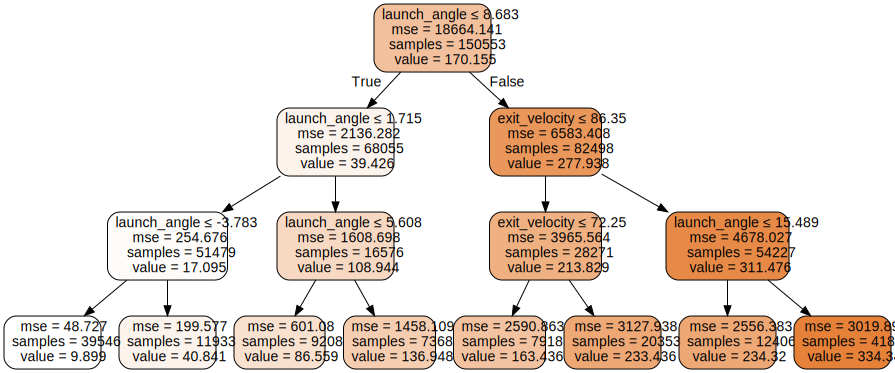

In [76]:
# Visualize decision tree
# Verbatim DOT source code string to be rendered by Graphviz
graph = graphviz.Source(dot_data)  
graph 

In [77]:
# Save the source to file and render with the Graphviz engine
# Note: view (bool): Open the rendered result with the default application
graph.render('hit_distance_sc', view=False)

'hit_distance_sc.pdf'

Note: Not needed anymore because 'graph.render' saves the source file after rendering

In [78]:
#with open('hit_distance_sc_regressor.txt', 'w') as f:
#    f = export_graphviz(estimator, out_file=f,
#                        feature_names=feature_cols,
#                        filled=True, rounded=True,
#                        special_characters=True)